# Markov chain transmission rate 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import seaborn as sns
import pandas as pd
import random

In [86]:
# Solves compartmental SIS model with transmission matrix beta (row: susceptible, column: infected)

class ConditionalSIS:
    def __init__(self, beta, gamma, initial_s, initial_i, endtime):
        self.cases = len(beta)
        self.b = beta
        self.k = gamma
        self.S_0 = initial_s
        self.I_0 = initial_i
        self.y0 = np.append(self.S_0, self.I_0)
        self.N = self.S_0 + self.I_0
        self.t0 = 0
        self.tEnd = endtime
        
        self.simulation = []
        self.timestamps = []
        
    def fun(self, t, y):
        stois = [] #susceptible to infected
        for idx in range(self.cases):
            # infection rate is the dot product between the corresponding row in the transmission matrix and all of the infection compartments
            infection_rate = np.matmul(self.b[idx], y[self.cases:2 * self.cases]/self.N) 
            recovered_population = self.k[idx] * y[self.cases + idx]
            stois.append(y[idx] * infection_rate - recovered_population)

        stois = np.array(stois)
        
        return np.append(-stois, stois) # dS = -stois, dI = stois

    def simulate(self):
        sol = solve_ivp(self.fun, [self.t0 , self.tEnd], self.y0, method='BDF')
        self.simulation = sol.y
        self.timestamps = sol.t
    
    def plot(self, compartment):
        for i in range(self.cases):
            plt.plot(self.timestamps, self.simulation[compartment * self.cases + i])
            


In [91]:
b = [[0.02, 0.02], [0.0002, 0.0002]]
k = [0.001, 0.001]

In [81]:
b = np.array([[0.1, 0.1], [1, 1]]) # row i indicates population i's transmission rate from each of the other infected populations
k = np.array([0.1, 0.05])

In [92]:
sis = ConditionalSIS(beta = b, gamma = k, initial_s = np.array([190, 100]), initial_i = np.array([10, 0]), endtime = 1000)

In [93]:
sis.simulate()

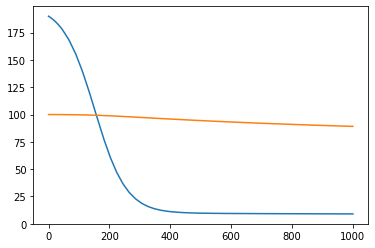

In [94]:
sis.plot(0)

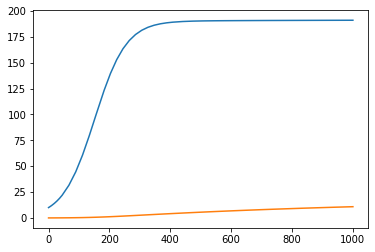

In [95]:
sis.plot(1)

In [71]:
# Solves compartmental SIR model with transmission matrix beta (row: susceptible, column: infected) and recovery vector gamma

class ConditionalSIR:
    def __init__(self, beta, gamma, initial_s, initial_i, initial_r, endtime):
        self.cases = len(beta)
        self.b = beta
        self.k = gamma
        self.S_0 = initial_s
        self.I_0 = initial_i
        self.R_0 = initial_r
        self.y0 = np.append(np.append(self.S_0, self.I_0), self.R_0)
        self.N = self.S_0 + self.I_0 + self.R_0
        self.t0 = 0
        self.tEnd = endtime
        
        self.simulation = []
        self.timestamps = []
        
    def fun(self, t, y):
        stois = [] #susceptible to infected
        itors = [] #infected to recovered
        for idx in range(self.cases):
            # infection rate is the dot product between the corresponding row in the transmission matrix and all of the infection compartments
            infection_rate = np.matmul(self.b[idx], y[self.cases:2 * self.cases]/self.N) 
            stois.append(y[idx] * infection_rate)
            itors.append(self.k[idx] * y[self.cases + idx])

        stois = np.array(stois)
        itors = np.array(itors)
        
        return np.append(np.append(-stois, stois - itors), itors) # dS = -stois, dI = stoid - itos, dR = itors

    def simulate(self):
        sol = solve_ivp(self.fun, [self.t0 , self.tEnd], self.y0, method='BDF')
        self.simulation = sol.y
        self.timestamps = sol.t
    
    def plot(self, compartment = 0):
        for i in range(self.cases):
            plt.plot(self.timestamps, self.simulation[compartment * self.cases + i])
            


In [72]:
sir = ConditionalSIR(beta = b, gamma = k, initial_s = np.array([190, 100]), initial_i = np.array([10, 0]), initial_r = np.array([0, 0]), endtime = 100)

In [73]:
sir.simulate()

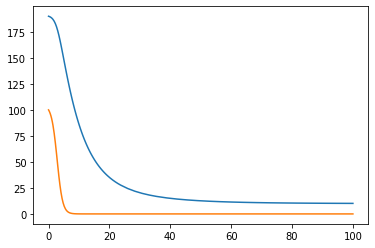

In [74]:
sir.plot()

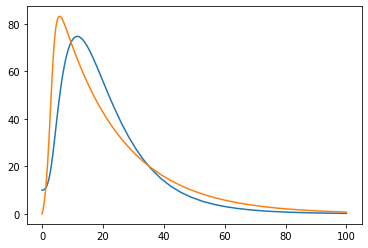

In [75]:
sir.plot(1)

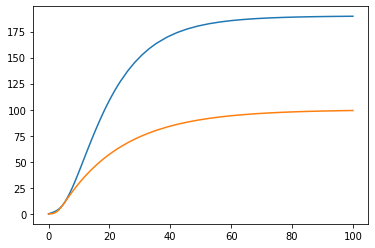

In [76]:
sir.plot(2)

In [59]:
k

[1e-05, 1e-05]

In [140]:
# Solves DTMC SIS model with transmission matrix beta (row: susceptible, column: infected) and recovery vector omega

class DTMCSIS:
    def __init__(self, beta, gamma, initial_s, initial_i, endtime):
        self.cases = len(beta)
        self.b = beta
        self.k = gamma
        self.S_0 = initial_s
        self.I_0 = initial_i
        self.timestamps = np.linspace(0, endtime, endtime + 1)
            
        self.N = np.array(self.S_0) + np.array(self.I_0)
        self.susceptible = [self.S_0]
        self.infected = [self.I_0]
        
    def trans_step(self, total, infected, total_vector, infected_vector, bvec, kval):
        p1 = (total - infected) * np.matmul(bvec, infected_vector/total_vector)
        p2 = kval * infected
        
        u = random.uniform(0,1)
        if u <= p1:
            return 1
        elif u <= p1 + p2:
            return -1
        else:
            return 0
    
    def simulate(self):
        self.N = np.array(self.S_0) + np.array(self.I_0)
        self.susceptible = [self.S_0]
        self.infected = [self.I_0]
        
        for _ in self.timestamps[1:]:
            curr_i = self.infected[-1].copy()
            for i in range(self.cases):
                infected_pop = curr_i[i]
                infected_pop += self.trans_step(self.N[i], infected_pop, self.N, curr_i, self.b[i], self.k[i])
                curr_i[i] = infected_pop

            self.susceptible.append(self.N - curr_i)
            self.infected.append(curr_i)
    
    def plot(self, compartment):
        arr = None
        if compartment == 0:
            arr = np.array(self.susceptible).T
        else:
            arr = np.array(self.infected).T

        for i in range(self.cases):
            plt.plot(self.timestamps, arr[i])
            


In [141]:
dsis = DTMCSIS(b, k, [190, 100], [10, 0], 1000)

In [142]:
dsis.simulate()

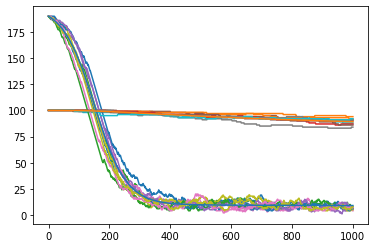

In [143]:
for i in range(10):
    dsis.simulate()
    dsis.plot(0)
sis.plot(0)
plt.show()

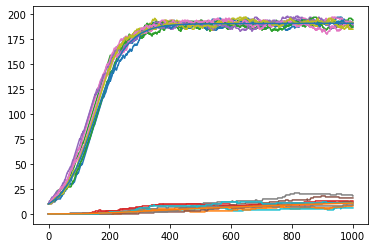

In [144]:
for i in range(10):
    dsis.simulate()
    dsis.plot(1)
sis.plot(1)
plt.show()

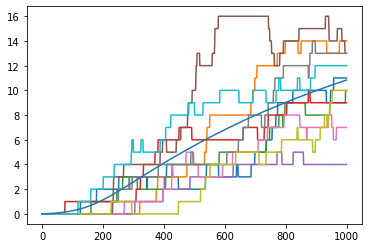

In [146]:
for i in range(10):
    dsis.simulate()
    plt.plot(dsis.timestamps, np.array(dsis.infected).T[1])
    
plt.plot(sis.timestamps, sis.simulation[sis.cases * 1 + 1])

plt.show()